In [33]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [34]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [35]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, cast, Date

In [36]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [37]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [38]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [39]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [40]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [41]:
#Created inspector
inspector = inspect(engine)
#Found column names and types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [104]:
#Found the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
recent_date

'2017-08-23'

In [105]:
#Calculated the date one year from the last date in data set.
year_ago = dt.datetime.strptime(recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

#Performed a query to retrieve the date and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date >= year_ago).\
                        order_by(Measurement.date).all()
                        
#Saved the query results as a Pandas DataFrame and set the index to the date column
precp_df = pd.DataFrame(results)
precp_df.set_index('date', inplace=True)

precp_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


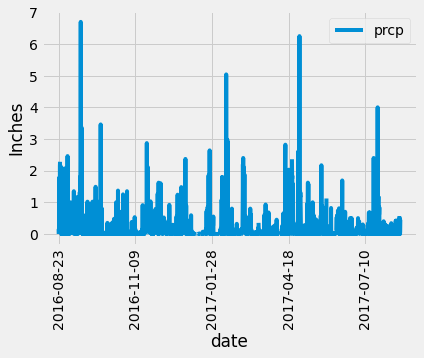

In [44]:
# Use Pandas Plotting with Matplotlib to plot the data
precp_df.plot()
plt.xticks(rotation=90)
plt.ylabel("Inches")
plt.show()

In [45]:
#Used Pandas to calcualte the summary statistics for the precipitation data
precp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [46]:
#Created inspector
inspector = inspect(engine)
#Found column names and types
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [47]:
#Found the total number of stations
locations = session.query(func.count(Station.station)).all()
print(f'There are {locations[0][0]} stations.')

There are 9 stations.


In [77]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

#Created query to how many rows each station had and printed the row count for each station
active_station = session.query(Measurement.station, func.count(Measurement.id)).\
                                group_by(Measurement.station).\
                                order_by(func.count(Measurement.id).desc()).all()
print('Active stations with number of row recorded')
print('-'*45)
for s in active_station:
    print(f'Station {s[0]} had {s[1]} rows recorded')
#Based on query results determined with station was the most active and printed that station    
most_active_station = active_station[0][0]
print('-'*45)
print(f'The most active station was station {most_active_station}')

Active stations with number of row recorded
---------------------------------------------
Station USC00519281 had 2772 rows recorded
Station USC00519397 had 2724 rows recorded
Station USC00513117 had 2709 rows recorded
Station USC00519523 had 2669 rows recorded
Station USC00516128 had 2612 rows recorded
Station USC00514830 had 2202 rows recorded
Station USC00511918 had 1979 rows recorded
Station USC00517948 had 1372 rows recorded
Station USC00518838 had 511 rows recorded
---------------------------------------------
The most active station was station USC00519281


In [85]:
#Calculated the lowest, highest, and average temperature based of the most avtive station found in the last query
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).all()

print(f'The lowest recored temperature at station {most_active_station} is {lowest_temp[0][0]} degrees')
print(f'The highest recored temperature at station {most_active_station} is {highest_temp[0][0]} degrees')
print(f'The average temperature at station {most_active_station} is {round(avg_temp[0][0], 1)} degrees')

The lowest recored temperature at station USC00519281 is 54.0 degrees
The highest recored temperature at station USC00519281 is 85.0 degrees
The average temperature at station USC00519281 is 71.7 degrees


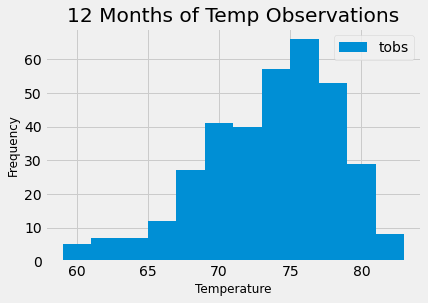

In [99]:
#Created query to find the temperature data for the last 12 months from the most active station
results = session.query(Measurement.date, Measurement.tobs).\
                        filter(Measurement.station == most_active_station).\
                        filter(Measurement.date >= year_ago).\
                        order_by(Measurement.tobs).all()

#Created dataframe from the query results in order to plot
temp_df = pd.DataFrame(results)
temp_df = temp_df.dropna()

#Created histogram to visualize the query results
temp_df.plot.hist(bins=12, title="12 Months of Temp Observations")
plt.xlabel("Temperature", fontsize=12)
plt.ylabel("Frequency",fontsize=12)

plt.show()

# Close session

In [100]:
#Closed Session
session.close()